In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats

In [30]:
df = pd.read_excel("/content/drive/MyDrive/Hugo's Portfolio/Introducing NBEATSx to Realized Volatility Forecasting (Research)/DJIA Realized Volatility.xlsx",index_col='Date',parse_dates=True)


In [32]:
df.tail()

,Realised,VIX
Date,,
2023-03-24,0.009888,21.740000
2023-03-27,0.005964,20.600000
2023-03-28,0.005121,19.969999
2023-03-29,0.006033,19.120001
2023-03-30,0.005385,19.020000


In [33]:
df_train=df[:int(len(df["Realised"])*0.7)]

Text(0, 0.5, 'Realized Volatility')

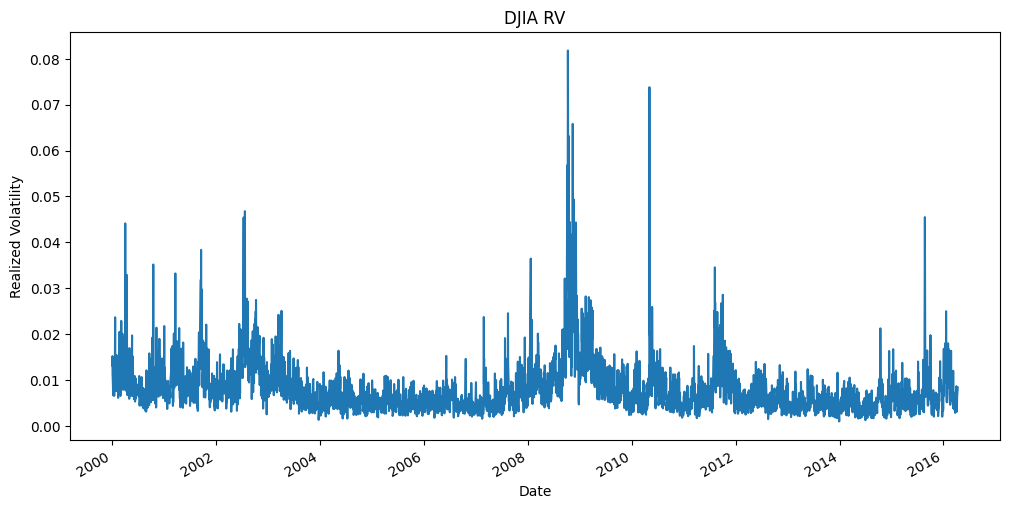

In [34]:
df_train["Realised"].plot(figsize=(12,6))
plt.title("DJIA RV")
plt.xlabel("Date")
plt.ylabel("Realized Volatility")

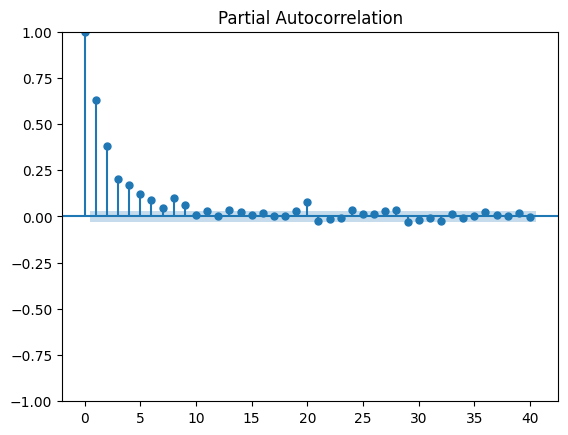

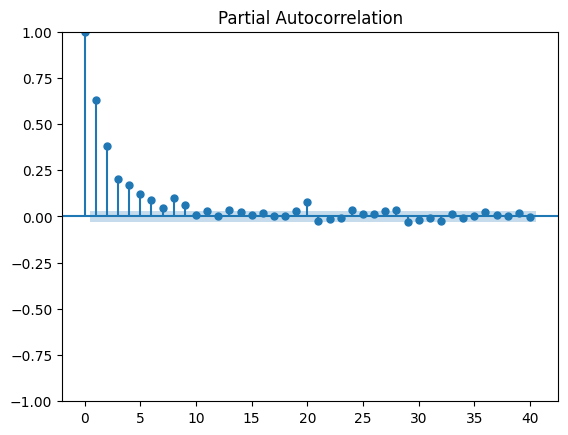

In [35]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_train["Realised"], lags = 40, method = "ols")

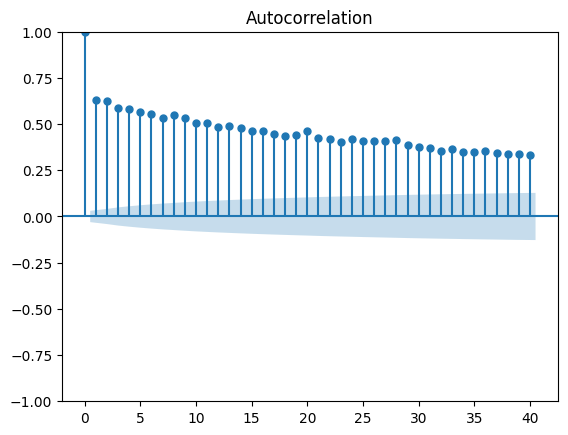

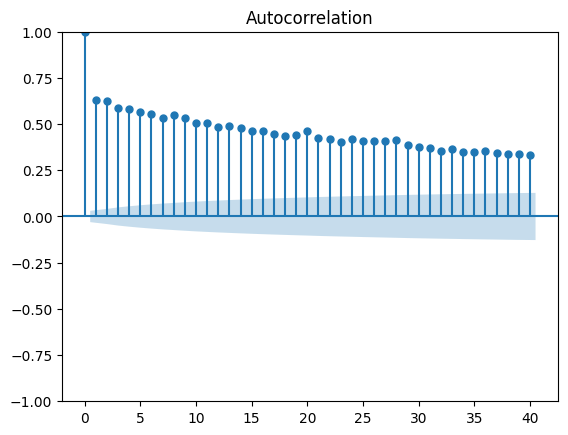

In [36]:
plot_acf(df_train["Realised"], lags = 40) 

Augmented Dickey Fuller test

In [37]:
from statsmodels.tsa.stattools import adfuller
adfuller(df_train["Realised"])

(-5.009389951568752,
 2.1262837784922017e-05,
 28,
 4063,
 {'1%': -3.4319604937833557,
  '5%': -2.862251627987355,
  '10%': -2.567148806635753},
 -33574.753601535725)

In [38]:
len(df_train["Realised"])

4092

Breusch Godfrey test

In [50]:
df_for_Breusch_Godfrey_test = df_train.reset_index(drop=True)

In [51]:
import statsmodels.api as sm
y = df_for_Breusch_Godfrey_test["Realised"]
x = df_for_Breusch_Godfrey_test[['Realised']][:len(df_train["Realised"])-1]

In [52]:
for i in range(len(y)-1):
    y[i]=y[i+1]

In [53]:
y=y[:len(df_train["Realised"])-1]

In [54]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

In [55]:
import statsmodels.stats.diagnostic as dg

In [56]:
print(dg.acorr_breusch_godfrey(model, nlags=10))

(936.445394458196, 9.094586651202892e-195, 121.75145949772204, 9.158708285542487e-223)


Ljung-Box Test

In [57]:
def sac(x, k=1):
    """
    ----------
    x : 1d numpy array
        Signal
    k : int or list of ints
        Lags to calculate sample autocorrelation for
    Returns
    -------
    res : scalar or np array
        The sample autocorrelation. A scalar value if k is a scalar, and a
        numpy array if k is a interable.
    """
    try:
        res = []
        for ki in k:
            res.append(sac(x, ki))
        return np.array(res)
    except:
        pass
    mx = np.mean(x)
    if k==0:
        N = np.sum((x-mx)*(x-mx))
    else:
        N = np.sum((x[:-k]-mx)*(x[k:]-mx))
    D = len(x) * np.var(x)
    return N/D


def ljungbox(x, lags, alpha=0.1):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2) / (n-k)
    Q = n*(n+2)*Q
    return Q

def boxpierce(x, lags, alpha=0.1):
    """
    The Box-Pierce test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2)
    Q = n*Q
    return Q

def lbqtest(x, lags, alpha=0.1, method='lb'):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : list of ints
        Lags being tested
    alpha : float
        Significance level used for the tests
    method : string
        Can be either 'lb' for Ljung-Box, or 'bp' for Box-Pierce
       
    Returns
    -------
    h : np array
        Numpy array of bool values, True == H0 hypothesis rejected
    pV : np array
        Test statistics p-values
    Q : np array
        Test statistics
    cV : np array
        Critical values used for determining if H0 should be rejected. The
        critical values are calculated from the given alpha and lag.
    """
    if method=='lb':
        findq = ljungbox
    else:
        findq = boxpierce
    n = len(x)
    Q = np.zeros(len(lags))
    pV = np.zeros(len(lags))
    cV = np.zeros(len(lags))
    for i, lag in enumerate(lags):
        Q[i] = findq(x, lag)
        pV[i] = 1.0 - scipy.stats.chi2.cdf(Q[i], lag)
        cV[i] = scipy.stats.chi2.ppf(1-alpha, lag)
    h = Q>cV
    return h, pV, Q, cV

In [58]:
h, pV, Q, cV = lbqtest(y, range(1, 25), alpha=0.1)
print ('lag   p-value          Q    c-value   rejectH0')
for i in range(len(h)):
    print ("%-2d %10.3f %10.3f %10.3f      %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

lag   p-value          Q    c-value   rejectH0
1       0.000   4090.786      2.706      True
2       0.000   8181.967      4.605      True
3       0.000  12273.680      6.251      True
4       0.000  16366.102      7.779      True
5       0.000  20458.320      9.236      True
6       0.000  24549.926     10.645      True
7       0.000  28642.504     12.017      True
8       0.000  32734.558     13.362      True
9       0.000  36827.109     14.684      True
10      0.000  40920.547     15.987      True
11      0.000  45010.760     17.275      True
12      0.000  49101.558     18.549      True
13      0.000  53176.531     19.812      True
14      0.000  57250.318     21.064      True
15      0.000  61323.787     22.307      True
16      0.000  65394.314     23.542      True
17      0.000  69465.468     24.769      True
18      0.000  73536.564     25.989      True
19      0.000  77608.431     27.204      True
20      0.000  81680.421     28.412      True
21      0.000  85749.431     29.6

In [59]:
from pandas.plotting import lag_plot

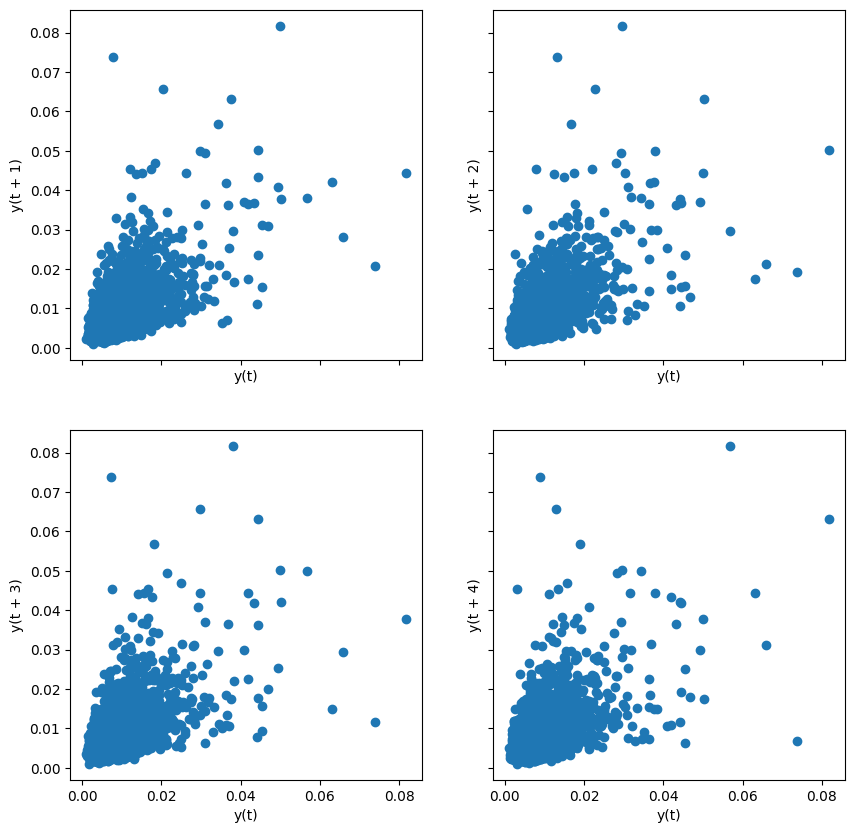

In [60]:
plot_lags = 10
rows = int(plot_lags/5)
cols = int(plot_lags/5)
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True)
fig.set_figwidth(plot_lags)
fig.set_figheight(plot_lags)
count =1
for i in range(rows):
    for j in range(cols):
        lag_plot(df_train["Realised"], lag=count, ax=axes[i, j])
        count+=1